In [1]:
#@title Imports 
import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl
import tjy_udf as tjy
print("tjy_udf: ", list(filter(lambda x: '__' not in x, dir(tjy)))) # Print contained functions
mpl.rc_file('tjy.mplstyle')

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)
DISPLAY_SORTED = True
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib import ticker
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
from matplotlib import animation, rc
from scipy.interpolate import UnivariateSpline
    
GIT = 'https://github.com/tyokokur/tmpdat/raw/main/int/'

###COOLWARM COLORMAP DOCUMENTATION  
#https://depts.washington.edu/airqual/coolwarm.m
#Base blue: RGB = [59 76 192]
#Base red:  RGB = [180 4 38]
warm_red = [180/255, 4/255, 38/255]
cool_blue = [59/255,76/255,192/255]
mix_purp = np.divide(np.add(warm_red,cool_blue),2).tolist()
COLORS = [(228/255,26/255,28/255), (55/255,126/255,184/255), (77/255,175/255,74/255), (152/255,78/255,163/255), (255/255,127/255,0/255)] # Colors from https://colorbrewer2.org/#type=qualitative&scheme=Set1&n=5

tjy_udf:  ['CalcF', 'H_find', 'Kap_D', 'git_sync', 'lighten_color', 'phread', 'plot_anim', 'plot_pha', 'plot_pha_feed', 'ticks']


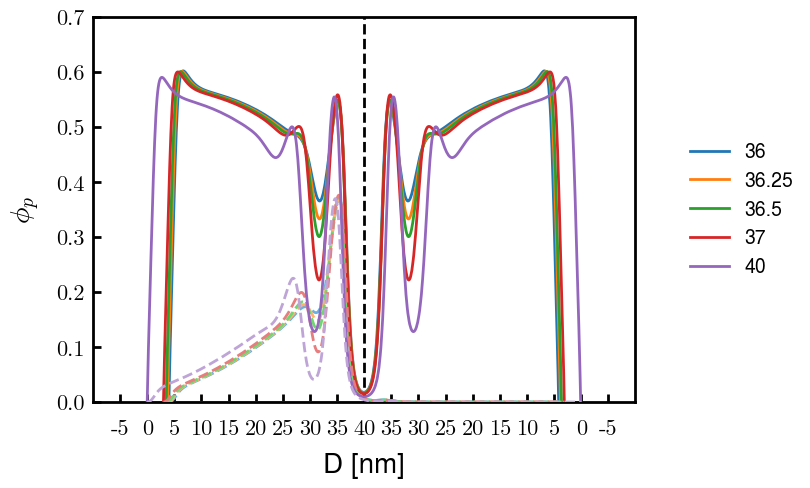

In [27]:
# SYSG Explore
labs = [36, 36.25, 36.5, 37, 40]
read_list = [GIT+'ph_2-2_d{:5d}.dat'.format(round(i*1000)) for i in labs]
max_d = round(max(labs)) #Distance to center (Lx/2)
shifts = [max_d-float(i) for i in labs]
fig, ax = tjy.plot_pha(read_list, x1_shift=shifts, block1_scale=1, block1=2, #block1=3 is block5, diff pha format for int runs
                       x1_start = -10, x1_end=max_d*2+10, y1_end=0.70, labs=labs, double=False, show=False)

plt.sca(ax)
plt.plot([max_d]*2,[0,1], '--', lw =2, color='k')
step = 5
xrange = np.arange(-step, max_d*2+step+0.1, step)
xsim = np.concatenate([np.arange(-step, max_d+0.1, step), np.arange(max_d-step, -step-0.1, -step)])
plt.xticks(xrange, ['{:.0f}'.format(i) for i in xsim])
plt.xlabel('D [nm]')
plt.legend(frameon=True, framealpha=1.0, facecolor='w', edgecolor='w', loc='center left', bbox_to_anchor=(1.05,0.5))
plt.show()

## $3 - 1\ (\alpha = 0.35,\ \chi = 1.10)$

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


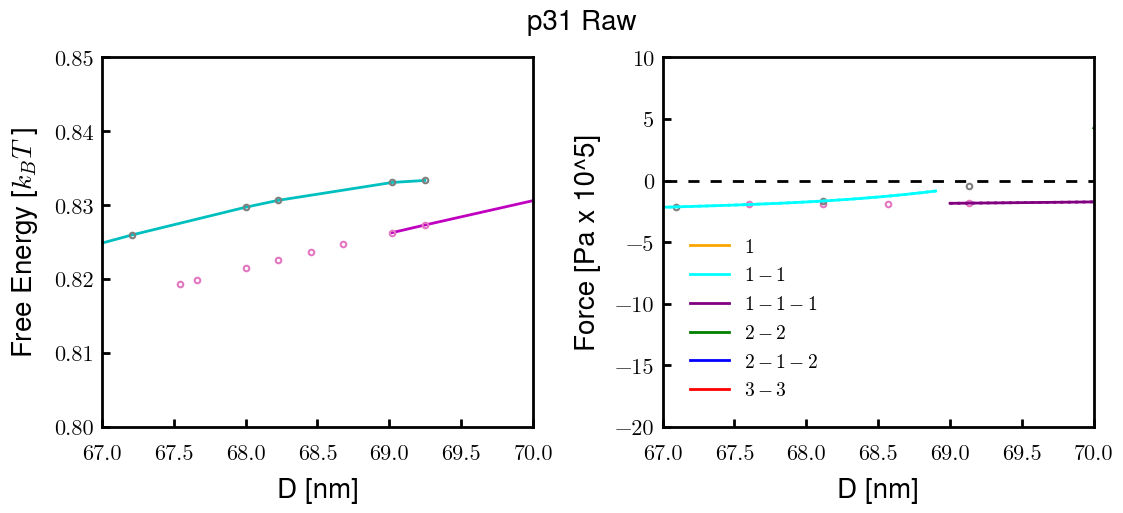

In [85]:
def get_fp(fname, fit=True):
    freeE = pd.read_csv(GIT+fname, sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
    nx, yp = freeE.nx, freeE.freeE
    dp, xp, fp = tjy.CalcF(nx, yp)
    pas = 4.04e-03 # Scaling to get from kBT/nm^3 to Pascals 
    scaling = 5 # For order unity y-axis
    pas *= 10**scaling
    fp = [i*pas for i in fp]
    
    if fit: 
        XX, YY = np.sort(xp), np.take_along_axis(np.array(fp), np.argsort(xp), 0)
        fits = UnivariateSpline(XX, YY, s=1e-8)
        return dp, yp, xp, fp, fits
    else: 
        return dp, yp, xp, fp

def get_fs(spline, start, trans1, trans2, end):
    def get_meta(spline, trans, start=0, direc='left'):
        ## direc: 'left' or 'right' or 'real'
        if direc=='left':
            xs = np.arange(start, trans, 0.1)
        if direc=='right':
            xs = np.arange(trans, start, 0.1)
        return xs, spline(xs)

    xleft, yleft = get_meta(spline, trans1, start, 'left')
    xreal, yreal = np.arange(trans1, trans2, 0.1), spline(np.arange(trans1, trans2, 0.1))
    xright, yright = get_meta(spline, trans1, end, 'right')
    return (xleft, yleft), (xreal, yreal), (xright, yright)

# final
colors = ['r', 'b', 'm', 'g', 'c', 'orange']
dp3_3, yp3_3, xp3_3, fp3_3, fits3_3 = get_fp('final-31-3_3.txt')
dp2_1_2, yp2_1_2, xp2_1_2, fp2_1_2, fits2_1_2 = get_fp('final-31-2_1_2.txt')
dp1_1_1, yp1_1_1, xp1_1_1, fp1_1_1, fits1_1_1 = get_fp('final-31-1_1_1.txt')
dp2_2, yp2_2, xp2_2, fp2_2, fits2_2 = get_fp('final-31-2_2.txt')
dp1_1, yp1_1, xp1_1, fp1_1, fits1_1 = get_fp('final-31-1_1.txt')
dp010, yp010, xp010, fp010, fits010 = get_fp('final-31-1.txt')

dp_f = [dp3_3, dp2_1_2, dp1_1_1, dp2_2, dp1_1, dp010]
yp_f = [yp3_3, yp2_1_2, yp1_1_1, yp2_2, yp1_1, yp010]
xp_f = [xp3_3, xp2_1_2, xp1_1_1, xp2_2, xp1_1, xp010]
fp_f = [fp3_3, fp2_1_2, fp1_1_1, fp2_2, fp1_1, fp010]

# raw data
dp1, yp1, xp1, fp1 = get_fp('p31_lx160.txt', fit=False)
dp2, yp2, xp2, fp2 = get_fp('p31_lx119.txt', fit=False)
dp3, yp3, xp3, fp3 = get_fp('p31_lx80.txt', fit=False)
dp4, yp4, xp4, fp4 = get_fp('p31_p33.txt', fit=False)
dp5, yp5, xp5, fp5 = get_fp('p31_p212.txt', fit=False)
dp6, yp6, xp6, fp6 = get_fp('p31_p22.txt', fit=False)
dp7, yp7, xp7, fp7 = get_fp('p31_p111.txt', fit=False)
dp8, yp8, xp8, fp8 = get_fp('p31_p11.txt', fit=False)
dp9, yp9, xp9, fp9 = get_fp('p31_p1.txt', fit=False)

dp_r = [dp1, dp2, dp3, dp4, dp5, dp6, dp7, dp8, dp9]
yp_r = [yp1, yp2, yp3, yp4, yp5, yp6, yp7, yp8, yp9]
xp_r = [xp1, xp2, xp3, xp4, xp5, xp6, xp7, xp8, xp9]
fp_r = [fp1, fp2, fp3, fp4, fp5, fp6, fp7, fp8, fp9]

## Plotting
fs = (plt.rcParams['figure.figsize'][0]*2,  plt.rcParams['figure.figsize'][1])
f, axs = plt.subplots(1,2, figsize=fs)
plt.subplots_adjust(wspace=0.3)

if 1: # freeE collected
    for dp, yp, c in zip(dp_f, yp_f, colors): axs[0].plot(dp, yp, c=c)
    
# if 1: # force collected
#     axs[1].plot(xp01, fp01, c='purple', label='1')
#     axs[1].plot(xp1_1, fp1_1, c='green', label='1-1')
#     axs[1].plot(xp1_1_1, fp1_1_1, c='blue', label='1-1-1')
#     axs[1].plot(xp2_2, fp2_2, c='red', label='2-2')
    
if 1: # freeE raw data
    kws = {'marker':'o', 'ms':4, "markerfacecolor":'none',  'lw':0}
    for dp, yp in zip(dp_r, yp_r): axs[0].plot(dp, yp, **kws)

if 1: # force raw data
    for xp, fp in zip(xp_r, fp_r): axs[1].plot(xp, fp, **kws)

if 1: # force fitted
    left, real, right = get_fs(fits1,-1, -1, 60, 60)
    axs[1].plot(left[0], left[1], c='orange', ls=':') 
    axs[1].plot(real[0], real[1], c='orange', ls='-', label=r'$1$')
    axs[1].plot(right[0], right[1], c='orange', ls=':')

    left, real, right = get_fs(fits1_1, 62, 62, 69, 69)
    axs[1].plot(left[0], left[1], c='cyan', ls=':') 
    axs[1].plot(real[0], real[1], c='cyan', ls='-', label=r'$1-1$')
    axs[1].plot(right[0], right[1], c='cyan', ls=':')

    left, real, right = get_fs(fits1_1_1, 69, 69, 74.5, 74.5)
    axs[1].plot(left[0], left[1], c='purple', ls=':') 
    axs[1].plot(real[0], real[1], c='purple', ls='-', label=r'$1-1-1$')
    axs[1].plot(right[0], right[1], c='purple', ls=':')
    
    left, real, right = get_fs(fits2_2, 70, 70, 75, 75)
    axs[1].plot(left[0], left[1], c='green', ls=':') 
    axs[1].plot(real[0], real[1], c='green', ls='-', label=r'$2-2$')
    axs[1].plot(right[0], right[1], c='green', ls=':')
    
    left, real, right = get_fs(fits2_1_2, 75, 75, 80, 80)
    axs[1].plot(left[0], left[1], c='blue', ls=':') 
    axs[1].plot(real[0], real[1], c='blue', ls='-', label=r'$2-1-2$')
    axs[1].plot(right[0], right[1], c='blue', ls=':')
    
    left, real, right = get_fs(fits3_3, 85, 85, 999, 999)
    axs[1].plot(left[0], left[1], c='red', ls=':') 
    axs[1].plot(real[0], real[1], c='red', ls='-', label=r'$3-3$')
    
axs[1].plot([0,100], [0,0], 'k', ls=(0,(4, 4)), lw=2, zorder=1)

plt.suptitle('p31 Raw', fontsize=20)
axs[0].set_ylabel('Free Energy 'r'[$k_BT~$]')
axs[0].set_ylim([0.70, None])
axs[0].set_xlim([45, 150])
axs[1].set_ylabel('Force [Pa x 10^5]')
axs[1].set_ylim([-20, 10])
axs[1].set_xlim([45, 150])

for ax in axs:
    ax.set_xlabel('D [nm]')
    ax.legend()

## ZOOM
# axs[0].set_xlim((79.0, 84)) # 3-3 <> 2-1-2
# axs[1].set_xlim((79.0, 84)) 
# axs[0].set_ylim((0.84, 0.86))

# axs[0].set_xlim((70, 80))  # 1-1-1 <> 2-1-2 <> 2-2
# axs[1].set_xlim((70, 80)) 
# axs[0].set_ylim((0.80, 0.85))

# axs[0].set_xlim((68, 72))  # 2-2 <> 1-1-1 
# axs[1].set_xlim((68, 72)) 
# axs[0].set_ylim((0.80, 0.85))

axs[0].set_xlim((67, 70))  # 1-1 <> 1-1-1 
axs[1].set_xlim((67, 70)) 
axs[0].set_ylim((0.80, 0.85))

# axs[0].set_xlim((54, 69)) # 1 <> 1-1
# axs[1].set_xlim((54, 69))
# axs[0].set_ylim((0.70, 0.85))

tjy.ticks(axs)
plt.show()

## $1\ (\alpha = 0.35,\ \chi = 2.00)$

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


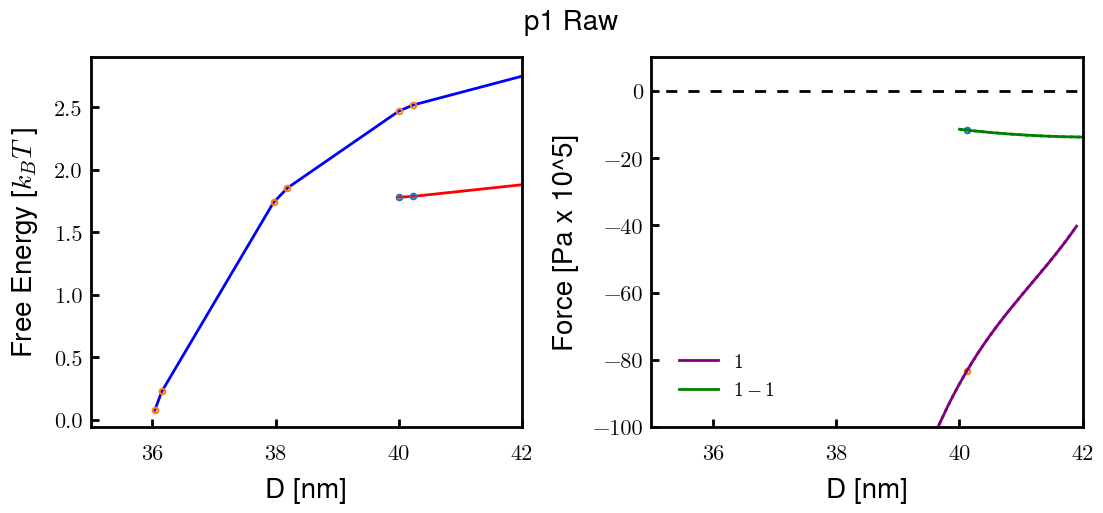

In [67]:
def get_fp(fname, fit=True):
    freeE = pd.read_csv(GIT+fname, sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
    nx, yp = freeE.nx, freeE.freeE
    dp, xp, fp = tjy.CalcF(nx, yp)
    pas = 4.04e-03 # Scaling to get from kBT/nm^3 to Pascals 
    scaling = 5 # For order unity y-axis
    pas *= 10**scaling
    fp = [i*pas for i in fp]
    
    if fit: 
        XX, YY = np.sort(xp), np.take_along_axis(np.array(fp), np.argsort(xp), 0)
        fits = UnivariateSpline(XX, YY, s=1e-5)
        return dp, yp, xp, fp, fits
    else: 
        return dp, yp, xp, fp

def get_fs(spline, start, trans1, trans2, end):
    def get_meta(spline, trans, start=0, direc='left'):
        ## direc: 'left' or 'right' or 'real'
        if direc=='left':
            xs = np.arange(start, trans, 0.1)
        if direc=='right':
            xs = np.arange(trans, start, 0.1)
        return xs, spline(xs)

    xleft, yleft = get_meta(spline, trans1, start, 'left')
    xreal, yreal = np.arange(trans1, trans2, 0.1), spline(np.arange(trans1, trans2, 0.1))
    xright, yright = get_meta(spline, trans1, end, 'right')
    return (xleft, yleft), (xreal, yreal), (xright, yright)

# final
dp1_1, yp1_1, xp1_1, fp1_1, fits1_1 = get_fp('final-1-1_1.txt')
dp010, yp010, xp010, fp010, fits010 = get_fp('final-1-1.txt')

dp_f = [dp1_1, dp010]
yp_f = [yp1_1, yp010]
xp_f = [xp1_1, xp010]
fp_f = [fp1_1, fp010]

# raw data
dp1, yp1, xp1, fp1 = get_fp('p1_lx61.txt', fit=False)
dp2, yp2, xp2, fp2 = get_fp('p1_p010.txt', fit=False)

dp_r = [dp1, dp2]
yp_r = [yp1, yp2]
xp_r = [xp1, xp2]
fp_r = [fp1, fp2]

## Plotting
fs = (plt.rcParams['figure.figsize'][0]*2,  plt.rcParams['figure.figsize'][1])
f, axs = plt.subplots(1,2, figsize=fs)
plt.subplots_adjust(wspace=0.3)

if 1: # freeE collected
    for dp, yp, c in zip(dp_f, yp_f, ['r', 'b']): axs[0].plot(dp, yp, c=c)
    
# if 1: # force collected
#     axs[1].plot(xp01, fp01, c='purple', label='1')
#     axs[1].plot(xp1_1, fp1_1, c='green', label='1-1')
#     axs[1].plot(xp1_1_1, fp1_1_1, c='blue', label='1-1-1')
#     axs[1].plot(xp2_2, fp2_2, c='red', label='2-2')
    
if 1: # freeE raw data
    kws = {'marker':'o', 'ms':4, "markerfacecolor":'none',  'lw':0}
    for dp, yp in zip(dp_r, yp_r): axs[0].plot(dp, yp, **kws)

if 1: # force raw data
    for xp, fp in zip(xp_r, fp_r): axs[1].plot(xp, fp, **kws)

if 1: # force fitted
    left, real, right = get_fs(fits010,-1, -1, 42, 42)
    axs[1].plot(left[0], left[1], c='purple', ls=':') 
    axs[1].plot(real[0], real[1], c='purple', ls='-', label=r'$1$')
    axs[1].plot(right[0], right[1], c='purple', ls=':')
    
    left, real, right = get_fs(fits1_1, 40, 40, 70, 70)
    axs[1].plot(left[0], left[1], c='green', ls=':') 
    axs[1].plot(real[0], real[1], c='green', ls='-', label=r'$1-1$')
    axs[1].plot(right[0], right[1], c='green', ls=':')
    
axs[1].plot([0,100], [0,0], 'k', ls=(0,(4, 4)), lw=2, zorder=1)

plt.suptitle('p1 Raw', fontsize=20)
axs[0].set_ylabel('Free Energy 'r'[$k_BT~$]')
# axs[0].set_ylim([0.30, 0.55])
axs[0].set_xlim([25, 70])
axs[1].set_ylabel('Force [Pa x 10^5]')
axs[1].set_ylim([-100, 10])
axs[1].set_xlim([25, 70])

for ax in axs:
    ax.set_xlabel('D [nm]')
    ax.legend()

## ZOOM
axs[0].set_xlim((35.0, 42)) 
axs[1].set_xlim((35.0, 42)) 
# axs[0].set_ylim((1.0, 2.75))

tjy.ticks(axs)
plt.show()

## $0\ (\alpha = 0.35,\ \chi = 0.60)$

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


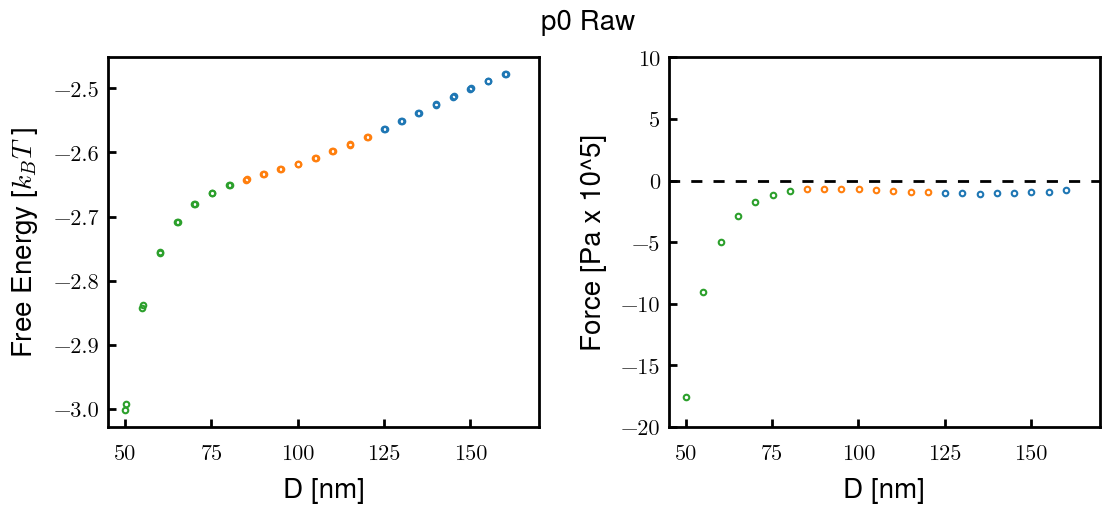

In [73]:
def get_fp(fname, fit=True):
    freeE = pd.read_csv(GIT+fname, sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
    nx, yp = freeE.nx, freeE.freeE
    dp, xp, fp = tjy.CalcF(nx, yp)
    pas = 4.04e-03 # Scaling to get from kBT/nm^3 to Pascals 
    scaling = 5 # For order unity y-axis
    pas *= 10**scaling
    fp = [i*pas for i in fp]
    
    if fit: 
        XX, YY = np.sort(xp), np.take_along_axis(np.array(fp), np.argsort(xp), 0)
        fits = UnivariateSpline(XX, YY, s=1e-5)
        return dp, yp, xp, fp, fits
    else: 
        return dp, yp, xp, fp

def get_fs(spline, start, trans1, trans2, end):
    def get_meta(spline, trans, start=0, direc='left'):
        ## direc: 'left' or 'right' or 'real'
        if direc=='left':
            xs = np.arange(start, trans, 0.1)
        if direc=='right':
            xs = np.arange(trans, start, 0.1)
        return xs, spline(xs)

    xleft, yleft = get_meta(spline, trans1, start, 'left')
    xreal, yreal = np.arange(trans1, trans2, 0.1), spline(np.arange(trans1, trans2, 0.1))
    xright, yright = get_meta(spline, trans1, end, 'right')
    return (xleft, yleft), (xreal, yreal), (xright, yright)

# final
# dp3_3, yp3_3, xp3_3, fp3_3, fits3_3 = get_fp('final-31-3_3.txt')
# dp2_1_2, yp2_1_2, xp2_1_2, fp2_1_2, fits2_1_2 = get_fp('final-31-2_1_2.txt')
# dp1_1_1, yp1_1_1, xp1_1_1, fp1_1_1 = get_fp('final-31-1_1_1.txt', fit=False)
# dp1_1_1, yp1_1_1, xp1_1_1, fp1_1_1, fits1_1_1 = get_fp('final-31-1_1_1.txt')

# dp_f = [dp3_3, dp2_1_2, dp1_1_1]
# yp_f = [yp3_3, yp2_1_2, yp1_1_1]
# xp_f = [xp3_3, xp2_1_2, xp1_1_1]
# fp_f = [fp3_3, fp2_1_2, fp1_1_1]

# raw data
dp1, yp1, xp1, fp1 = get_fp('p0_lx160.txt', fit=False)
dp2, yp2, xp2, fp2 = get_fp('p0_lx119.txt', fit=False)
dp3, yp3, xp3, fp3 = get_fp('p0_lx80.txt', fit=False)

dp_r = [dp1, dp2, dp3]
yp_r = [yp1, yp2, yp3]
xp_r = [xp1, xp2, xp3]
fp_r = [fp1, fp2, fp3]

## Plotting
fs = (plt.rcParams['figure.figsize'][0]*2,  plt.rcParams['figure.figsize'][1])
f, axs = plt.subplots(1,2, figsize=fs)
plt.subplots_adjust(wspace=0.3)

# if 1: # freeE collected
#     for dp, yp, c in zip(dp_f, yp_f, ['r', 'b', 'g']): axs[0].plot(dp, yp, c=c)
    
# if 1: # force collected
#     axs[1].plot(xp01, fp01, c='purple', label='1')
#     axs[1].plot(xp1_1, fp1_1, c='green', label='1-1')
#     axs[1].plot(xp1_1_1, fp1_1_1, c='blue', label='1-1-1')
#     axs[1].plot(xp2_2, fp2_2, c='red', label='2-2')
    
if 1: # freeE raw data
    kws = {'marker':'o', 'ms':4, "markerfacecolor":'none',  'lw':0}
    for dp, yp in zip(dp_r, yp_r): axs[0].plot(dp, yp, **kws)

if 1: # force raw data
    for xp, fp in zip(xp_r, fp_r): axs[1].plot(xp, fp, **kws)

# if 1: # force fitted
#     left, real, right = get_fs(fits01,-1, -1, 61, 62.5)
#     axs[1].plot(left[0], left[1], c='purple', ls=':') 
#     axs[1].plot(real[0], real[1], c='purple', ls='-', label=r'$1$')
#     axs[1].plot(right[0], right[1], c='purple', ls=':')
    
#     left, real, right = get_fs(fits1_1, 60.5, 61, 66, 68.5)
#     axs[1].plot(left[0], left[1], c='green', ls=':') 
#     axs[1].plot(real[0], real[1], c='green', ls='-', label=r'$1-1$')
#     axs[1].plot(right[0], right[1], c='green', ls=':')
    
#     left, real, right = get_fs(fits2_1_2, 75, 75, 80, 80)
#     axs[1].plot(left[0], left[1], c='blue', ls=':') 
#     axs[1].plot(real[0], real[1], c='blue', ls='-', label=r'$2-1-2$')
#     axs[1].plot(right[0], right[1], c='blue', ls=':')
    
#     left, real, right = get_fs(fits3_3, 79, 79, 999, 999)
#     axs[1].plot(left[0], left[1], c='red', ls=':') 
#     axs[1].plot(real[0], real[1], c='red', ls='-', label=r'$3-3$')
    
axs[1].plot([0,200], [0,0], 'k', ls=(0,(4, 4)), lw=2, zorder=1)

plt.suptitle('p0 Raw', fontsize=20)
axs[0].set_ylabel('Free Energy 'r'[$k_BT~$]')
# axs[0].set_ylim([0.30, 0.55])
axs[0].set_xlim([45, 170])
axs[1].set_ylabel('Force [Pa x 10^5]')
axs[1].set_ylim([-20, 10])
axs[1].set_xlim([45, 170])

for ax in axs:
    ax.set_xlabel('D [nm]')
    ax.legend()

## ZOOM
# axs[0].set_xlim((70.0, 140)) # 3-3 <> 2-1-2
# axs[1].set_xlim((70.0, 140)) 
# axs[0].set_ylim((0.80, 0.90))

# axs[0].set_xlim((70, 80))  # 1-1-1 <> 2-1-2
# axs[1].set_xlim((70, 80)) 
# axs[0].set_ylim((0.80, 0.85))

tjy.ticks(axs)
plt.show()

## PREVIOUS 2Cd ($\alpha = 0.31,\ \chi = 1.05$)

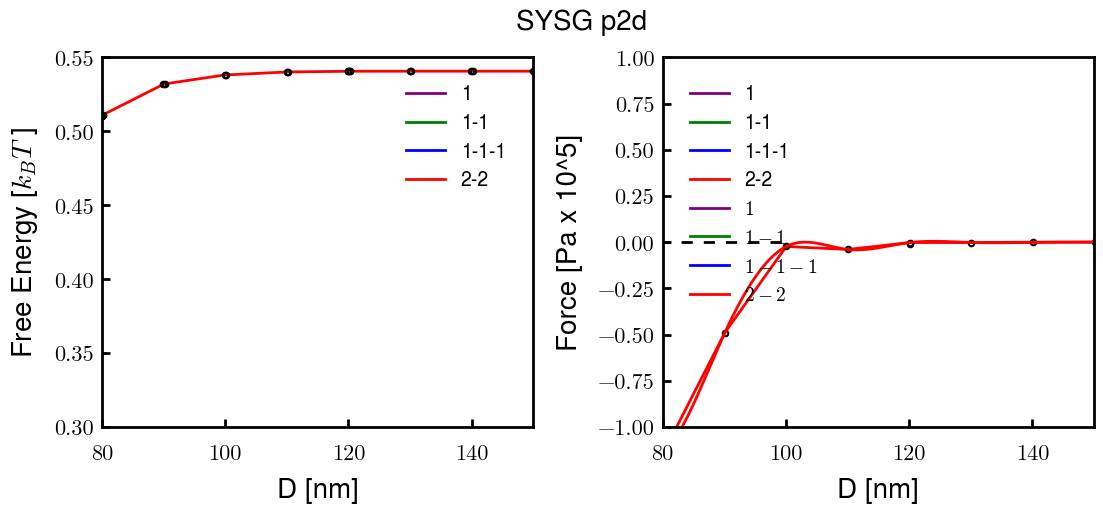

In [24]:
def get_fp(fname, fit=False):
    freeE = pd.read_csv(GIT+fname, sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
    nx, yp = freeE.nx, freeE.freeE
    dp, xp, fp = tjy.CalcF(nx, yp)
    pas = 4.04e-03 # Scaling to get from kBT/nm^3 to Pascals 
    scaling = 5 # For order unity y-axis
    pas *= 10**scaling
    fp = [i*pas for i in fp]
    
    if fit: 
        XX, YY = np.sort(xp), np.take_along_axis(np.array(fp), np.argsort(xp), 0)
        fits = UnivariateSpline(XX, YY, s=1e-4)
        return dp, yp, xp, fp, fits
    else: 
        return dp, yp, xp, fp

def get_fs(spline, start, trans1, trans2, end):
    def get_meta(spline, trans, start=0, direc='left'):
        ## direc: 'left' or 'right' or 'real'
        if direc=='left':
            xs = np.arange(start, trans, 0.1)
        if direc=='right':
            xs = np.arange(trans, start, 0.1)
        return xs, spline(xs)

    xleft, yleft = get_meta(spline, trans1, start, 'left')
    xreal, yreal = np.arange(trans1, trans2, 0.1), spline(np.arange(trans1, trans2, 0.1))
    xright, yright = get_meta(spline, trans1, end, 'right')
    return (xleft, yleft), (xreal, yreal), (xright, yright)

# collected
dp2_2, yp2_2, xp2_2, fp2_2, fits2_2 = get_fp('final-2_2.txt', True)
dp1_1_1, yp1_1_1, xp1_1_1, fp1_1_1, fits1_1_1 = get_fp('final-1_1_1.txt', True)
dp1_1, yp1_1, xp1_1, fp1_1, fits1_1 = get_fp('final-1_1.txt', True)
dp01, yp01, xp01, fp01, fits01 = get_fp('final-1.txt', True)

# raw data
dp1, yp1, xp1, fp1 = get_fp('lx200.txt')
dp2, yp2, xp2, fp2 = get_fp('lx160.txt')
dp3, yp3, xp3, fp3 = get_fp('lx120.txt')
dp4, yp4, xp4, fp4 = get_fp('lx80.txt')
dp5, yp5, xp5, fp5 = get_fp('p1.txt')
dp6, yp6, xp6, fp6 = get_fp('p11.txt')
dp7, yp7, xp7, fp7 = get_fp('p111.txt')
dp8, yp8, xp8, fp8 = get_fp('p22.txt')

## Plotting
fs = (plt.rcParams['figure.figsize'][0]*2,  plt.rcParams['figure.figsize'][1])
f, axs = plt.subplots(1,2, figsize=fs)
plt.subplots_adjust(wspace=0.3)

if 1: # freeE collected
    axs[0].plot(dp01, yp01, c='purple', label='1')
    axs[0].plot(dp1_1, yp1_1, c='green', label='1-1')
    axs[0].plot(dp1_1_1, yp1_1_1, c='blue', label='1-1-1')
    axs[0].plot(dp2_2, yp2_2, c='red', label='2-2')
    
if 1: # force collected
    axs[1].plot(xp01, fp01, c='purple', label='1')
    axs[1].plot(xp1_1, fp1_1, c='green', label='1-1')
    axs[1].plot(xp1_1_1, fp1_1_1, c='blue', label='1-1-1')
    axs[1].plot(xp2_2, fp2_2, c='red', label='2-2')
    
if 1: # freeE raw data
    kws = {'marker':'o', 'ms':4, "markerfacecolor":'none',  'c':'k', 'lw':0}
    axs[0].plot(dp1, yp1,**kws)
    axs[0].plot(dp2, yp2,**kws)
    axs[0].plot(dp3, yp3,**kws)
    axs[0].plot(dp4, yp4,**kws)
    axs[0].plot(dp5, yp5,**kws)
    axs[0].plot(dp6, yp6,**kws)
    axs[0].plot(dp7, yp7,**kws)
    axs[0].plot(dp8, yp8,**kws)

if 1: # force raw data
    axs[1].plot(xp1, fp1,**kws)
    axs[1].plot(xp2, fp2,**kws)
    axs[1].plot(xp3, fp3,**kws)
    axs[1].plot(xp4, fp4,**kws)
    axs[1].plot(xp5, fp5,**kws)
    axs[1].plot(xp6, fp6,**kws)
    axs[1].plot(xp7, fp7,**kws)
    axs[1].plot(xp8, fp8,**kws)

if 1: # force fitted
    left, real, right = get_fs(fits01,-1, -1, 61, 62.5)
    axs[1].plot(left[0], left[1], c='purple', ls=':') 
    axs[1].plot(real[0], real[1], c='purple', ls='-', label=r'$1$')
    axs[1].plot(right[0], right[1], c='purple', ls=':')
    
    left, real, right = get_fs(fits1_1, 60.5, 61, 66, 68.5)
    axs[1].plot(left[0], left[1], c='green', ls=':') 
    axs[1].plot(real[0], real[1], c='green', ls='-', label=r'$1-1$')
    axs[1].plot(right[0], right[1], c='green', ls=':')
    
    left, real, right = get_fs(fits1_1_1, 66, 67, 73, 75)
    axs[1].plot(left[0], left[1], c='blue', ls=':') 
    axs[1].plot(real[0], real[1], c='blue', ls='-', label=r'$1-1-1$')
    axs[1].plot(right[0], right[1], c='blue', ls=':')
    
    left, real, right = get_fs(fits2_2, 70, 73, 999, 999)
    axs[1].plot(left[0], left[1], c='red', ls=':') 
    axs[1].plot(real[0], real[1], c='red', ls='-', label=r'$2-2$')
    
axs[1].plot([0,100], [0,0], 'k', ls=(0,(4, 4)), lw=2, zorder=1)

plt.suptitle('SYSG p2d', fontsize=20)
axs[0].set_ylabel('Free Energy 'r'[$k_BT~$]')
axs[0].set_ylim([0.30, 0.55])
axs[0].set_xlim([55, 80])
axs[1].set_ylabel('Force [Pa x 10^5]')
axs[1].set_ylim([-20, 10])
axs[1].set_xlim([45, 120])

for ax in axs:
    ax.set_xlabel('D [nm]')
    ax.legend()

## ZOOM
# axs[0].set_xlim((60.0, 62.5)) # 1 <> 1-1
# axs[1].set_xlim((60.0, 62.5)) # 1 <> 1-1

axs[0].set_xlim((80, 150)) 
axs[1].set_xlim((80, 150)) 
axs[1].set_ylim((-1, 1))    

tjy.ticks(axs)
# f.savefig('./imgs/force_tmp.pdf')
plt.show()

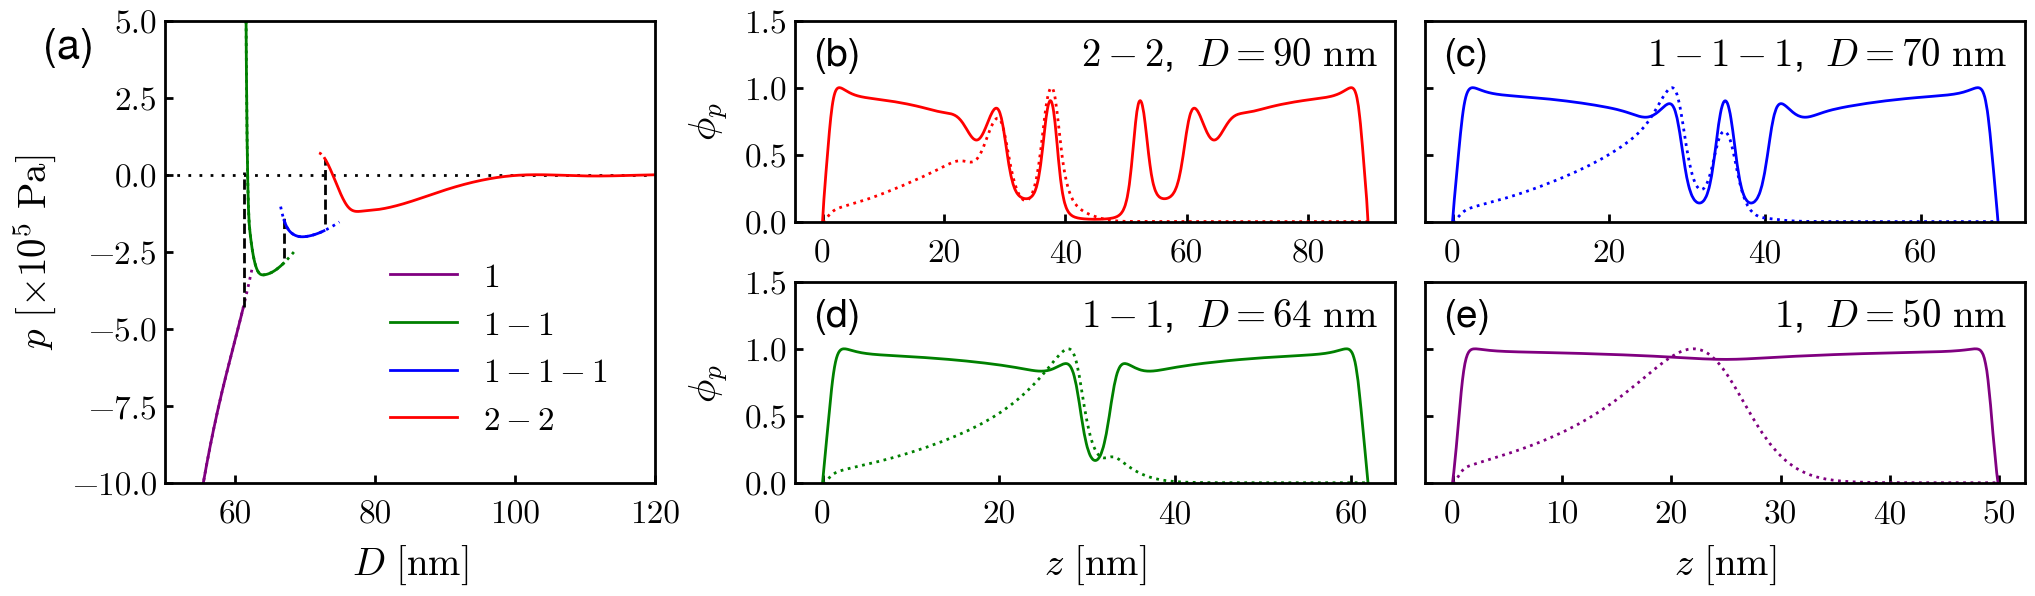

In [ ]:
mpl.rcParams['axes.labelsize'] = 28
mpl.rcParams['xtick.labelsize'] = 24
mpl.rcParams['ytick.labelsize'] = 24

def get_fp(fname, fit=False):
    freeE = pd.read_csv(GIT+fname, sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
    nx, yp = freeE.nx, freeE.freeE
    dp, xp, fp = tjy.CalcF(nx, yp)
    pas = 4.04e-03 # Scaling to get from kBT/nm^3 to Pascals 
    scaling = 5 # For order unity y-axis
    pas *= 10**scaling
    fp = [i*pas for i in fp]
    
    if fit: 
        XX, YY = np.sort(xp), np.take_along_axis(np.array(fp), np.argsort(xp), 0)
        fits = UnivariateSpline(XX, YY, s=1e-4)
        return dp, yp, xp, fp, fits
    else: 
        return dp, yp, xp, fp

def get_fs(spline, start, trans1, trans2, end):
    def get_meta(spline, trans, start=0, direc='left'):
        ## direc: 'left' or 'right' or 'real'
        if direc=='left':
            xs = np.arange(start, trans, 0.1)
        if direc=='right':
            xs = np.arange(trans, start, 0.1)
        return xs, spline(xs)

    xleft, yleft = get_meta(spline, trans1, start, 'left')
    xreal, yreal = np.arange(trans1, trans2, 0.1), spline(np.arange(trans1, trans2, 0.1))
    xright, yright = get_meta(spline, trans1, end, 'right')
    return (xleft, yleft), (xreal, yreal), (xright, yright)

def phread(fname): 
    ph = pd.read_csv(fname, sep="\s+", skiprows=0, header=None)
    return (ph[0], ph[1]/np.max(ph[1]), ph[7]/np.max(ph[7]))

fig = plt.figure(figsize=(24, 6))
gs_left = plt.GridSpec(1, 3, wspace=0.40)
gs_right= plt.GridSpec(2, 3, hspace=0.30, wspace=0.05)

p_ax =fig.add_subplot(gs_left[0])
ph_axes = np.array([fig.add_subplot(gs_right[i,j+1]) for i in range(2) for j in range(2)]).reshape([2,2])

## Forces
p_ax.plot([0,120], [0,0], 'k', ls=(0,(1, 3)), lw=2, zorder=1)

t01_11 = 61.2
dp01, yp01, xp01, fp01, fits01 = get_fp('final-1.txt', True)
left, real, right = get_fs(fits01,-1, -1, t01_11, 62.5)
p_ax.plot(left[0], left[1], c='purple', ls=':') 
p_ax.plot(real[0], real[1], c='purple', ls='-', label=r'$1$')
p_ax.plot(right[0], right[1], c='purple', ls=':')
p_ax.plot([t01_11,t01_11], [-4.3,0.1], 'k', ls='--')

t11_111 = 67
dp1_1, yp1_1, xp1_1, fp1_1, fits1_1 = get_fp('final-1_1.txt', True)
left, real, right = get_fs(fits1_1, 60.5, t01_11, t11_111, 68.5)
p_ax.plot(left[0], left[1], c='green', ls=':') 
p_ax.plot(real[0], real[1], c='green', ls='-', label=r'$1-1$')
p_ax.plot(right[0], right[1], c='green', ls=':')
p_ax.plot([t11_111,t11_111], [-2.7,-1.4], 'k', ls='--')

t111_22 = 72.8
dp1_1_1, yp1_1_1, xp1_1_1, fp1_1_1, fits1_1_1 = get_fp('final-1_1_1.txt', True)
left, real, right = get_fs(fits1_1_1, 66.5, t11_111, t111_22, 75)
p_ax.plot(left[0], left[1], c='blue', ls=':') 
p_ax.plot(real[0], real[1], c='blue', ls='-', label=r'$1-1-1$')
p_ax.plot(right[0], right[1], c='blue', ls=':')
p_ax.plot([t111_22,t111_22], [-1.6,0.5], 'k', ls='--')

dp2_2, yp2_2, xp2_2, fp2_2, fits2_2 = get_fp('final-2_2.txt', True)
left, real, right = get_fs(fits2_2, 72.0, t111_22, 999, 999)
p_ax.plot(left[0], left[1], c='red', ls=':') 
p_ax.plot(real[0], real[1], c='red', ls='-', label=r'$2-2$')

## PHAS
ph = phread(GIT + 'ph_2-2_d45000.dat')
ph_axes[0][0].plot(ph[0], ph[1], c='red')
ph_axes[0][0].plot(ph[0], ph[2], c='red', ls=':')
ph = phread(GIT + 'ph_1-1-1_d35000.dat')
ph_axes[0][1].plot(ph[0], ph[1], c='blue')
ph_axes[0][1].plot(ph[0], ph[2], c='blue', ls=':')
ph = phread(GIT + 'ph_1-1_d31000.dat')
ph_axes[1][0].plot(ph[0], ph[1], c='green')
ph_axes[1][0].plot(ph[0], ph[2], c='green', ls=':')
ph = phread(GIT + 'ph_1_d25000.dat')
ph_axes[1][1].plot(ph[0], ph[1], c='purple')
ph_axes[1][1].plot(ph[0], ph[2], c='purple', ls=':')

## FORMATTING
p_ax.text(-0.25, 0.92, '(a)', transform=p_ax.transAxes, fontsize=30)
p_ax.set(**{
    'xlim':(50,120),
    'ylim':(-10, 5),
    'xlabel': r'$D~[\mathrm{nm}]$',
    'ylabel': r'$p~[\times 10^5~\mathrm{Pa}]$',
    # 'yticks': [-7.5, -5, -2.5, 0, 2.5]
})
p_ax.legend(fontsize=24)

for i, lab, morph, dist in zip(ph_axes.flatten(), ('b', 'c', 'd', 'e'), (r'$2-2$', r'$1-1-1$', r'$1-1$', r'$1$'), (90, 70, 64, 50)):
    i.text(0.03, 0.78, '({:s})'.format(lab), transform=i.transAxes, fontsize=28)
    i.text(0.97, 0.78, r'{:s},  $D = {:d}$'.format(morph, dist)+r'$~\mathrm{nm}$', ha='right', transform=i.transAxes, fontsize=28)
    i.set_ylim((0,1.5))
    if (lab == 'b') or (lab == 'd'): i.set_ylabel(r'$\phi_p$')
    if (lab == 'd') or (lab == 'e'): i.set_xlabel(r'$z~[\mathrm{nm}]$')
    if (lab == 'c') or (lab == 'e'): i.set_yticklabels([])

tjy.ticks([p_ax, *ph_axes.flatten()])
fig.savefig('./imgs/force.pdf')
plt.show()

## Reset
mpl.rcParams['axes.labelsize']  = 20
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16

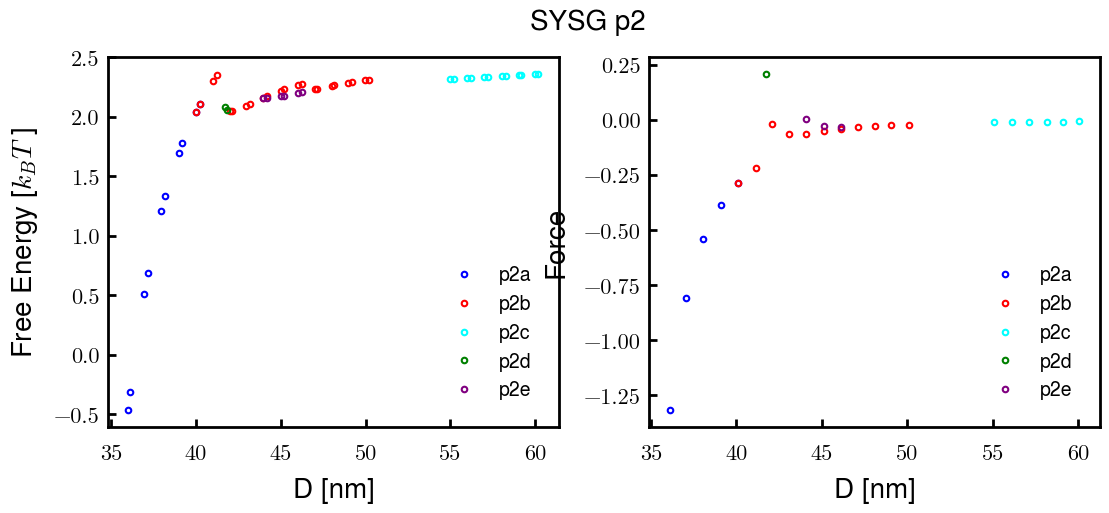

In [6]:
freeE = pd.read_csv(GIT+'p21C.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, yp21C = freeE.nx, freeE.freeE
dp21C, xp21C, fp21C = CalcF(nx, yp21C)
freeE = pd.read_csv(GIT+'p2b.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, yp2b = freeE.nx, freeE.freeE
dp2b, xp2b, fp2b = CalcF(nx, yp2b)
freeE = pd.read_csv(GIT+'p2c_1-12.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, yp2c = freeE.nx, freeE.freeE
dp2c, xp2c, fp2c = CalcF(nx, yp2c)
freeE = pd.read_csv(GIT+'p2d.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, yp2d = freeE.nx, freeE.freeE
dp2d, xp2d, fp2d = CalcF(nx, yp2d)
freeE = pd.read_csv(GIT+'p2e.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, yp2e = freeE.nx, freeE.freeE
dp2e, xp2e, fp2e = CalcF(nx, yp2e)

## Plotting
fs = (plt.rcParams['figure.figsize'][0]*2,  plt.rcParams['figure.figsize'][1])
f, axs = plt.subplots(1,2, figsize=fs)

if 1: 
    axs[0].plot(dp21C, yp21C, 'o', ms=4, markerfacecolor='none',  c='blue',  label='p2a')
    axs[0].plot(dp2b, yp2b, 'o', ms=4, markerfacecolor='none',  c='red',  label='p2b')
    axs[0].plot(dp2c, yp2c, 'o', ms=4, markerfacecolor='none',  c='cyan',  label='p2c')
    axs[0].plot(dp2d, yp2d, 'o', ms=4, markerfacecolor='none',  c='green',  label='p2d')
    axs[0].plot(dp2e, yp2e, 'o', ms=4, markerfacecolor='none',  c='purple',  label='p2e')
# axs[0].plot(dp21C, yp21C, c='blue',  label='_')
# axs[0].plot(dp2b, yp2b, c='red',  label='_')

if 1:
    axs[1].plot(xp21C, fp21C, 'o', ms=4, markerfacecolor='none', c='blue',  label='p2a')
    axs[1].plot(xp2b, fp2b, 'o', ms=4, markerfacecolor='none', c='red',  label='p2b')
    axs[1].plot(xp2c, fp2c, 'o', ms=4, markerfacecolor='none', c='cyan',  label='p2c')
    axs[1].plot(xp2d, fp2d, 'o', ms=4, markerfacecolor='none', c='green',  label='p2d')
    axs[1].plot(xp2e, fp2e, 'o', ms=4, markerfacecolor='none', c='purple',  label='p2e')
# axs[1].plot(xp21C, fp21C, c='blue', label='_')
# axs[1].plot(xp2b, fp2b, c='red', label='_')

plt.suptitle('SYSG p2', fontsize=20)
axs[0].set_xlabel('D [nm]')
axs[0].set_ylabel('Free Energy 'r'[$k_BT~$]')
axs[0].legend()
axs[1].legend()
axs[1].set_xlabel('D [nm]')
axs[1].set_ylabel('Force')

tjy.ticks(axs)
plt.show()

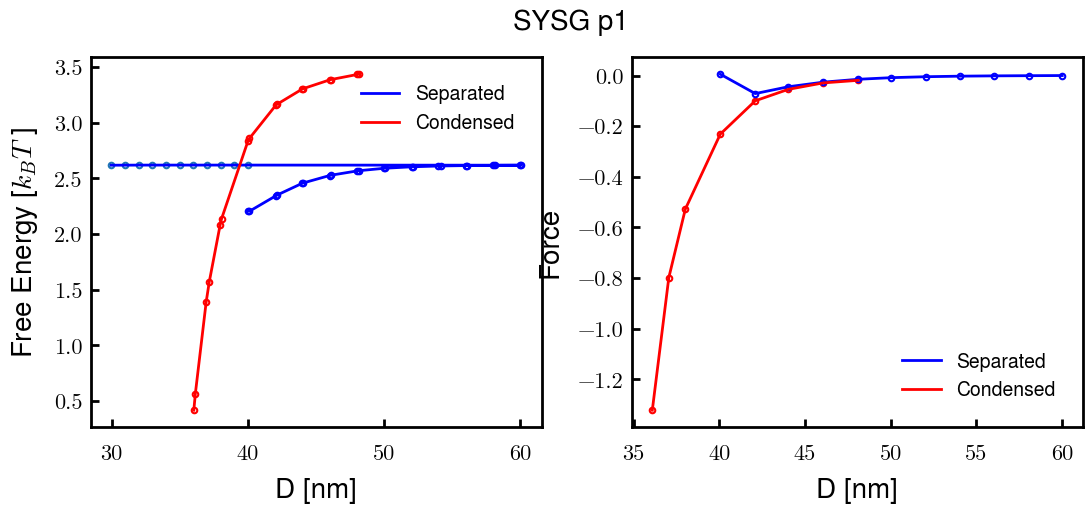

In [4]:
freeE = pd.read_csv(GIT+'p1_4030.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
d4030, y4030 = freeE.nx*17/150/2, freeE.freeE
freeE = pd.read_csv(GIT+'p1_c2520.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, yc2520 = freeE.nx, freeE.freeE
dc2520, xc2520, fc2520 = CalcF(nx, yc2520)
freeE = pd.read_csv(GIT+'p1_s3020.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, ys3020 = freeE.nx, freeE.freeE
ds3020, xs3020, fs3020 = CalcF(nx, ys3020)
freeE = pd.read_csv(GIT+'p1_c1915.txt', sep="\s+", skiprows=0, names = ['it', 'nx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='nx', ignore_index=True)
nx, yc1915 = freeE.nx, freeE.freeE
dc1915, xc1915, fc1915 = CalcF(nx, yc1915)

## Plotting
fs = (plt.rcParams['figure.figsize'][0]*2,  plt.rcParams['figure.figsize'][1])
f, axs = plt.subplots(1,2, figsize=fs)

if 1: 
    axs[0].plot(d4030, y4030, 'o', ms=4, markerfacecolor='none',  c='C0',  label='_4030')
    axs[0].plot(dc2520, yc2520, 'o', ms=4, markerfacecolor='none',  c='red',  label='_c2520')
    axs[0].plot(dc1915, yc1915, 'o', ms=4, markerfacecolor='none', c='red',  label='_c1915')
    axs[0].plot(ds3020, ys3020, 'o', ms=4, markerfacecolor='none',  c='blue',  label='_s3020')
axs[0].plot([*d4030, *ds3020[::-1]], [*y4030, *ys3020[::-1]], c='blue', label='Separated')
axs[0].plot([*dc2520[::-1], *dc1915[::-1]], [*yc2520[::-1], *yc1915[::-1]], c='red', label='Condensed')

if 1:
    axs[1].plot(xc2520, fc2520, 'o', ms=4, markerfacecolor='none', c='red',  label='_c2520')
    axs[1].plot(xc1915, fc1915, 'o', ms=4, markerfacecolor='none', c='red',  label='_c1915')
    axs[1].plot(xs3020, fs3020, 'o', ms=4, markerfacecolor='none', c='blue',  label='_s3020')
axs[1].plot([*xs3020[::-1]], [*fs3020[::-1]], c='blue', label='Separated')
axs[1].plot([*xc2520[::-1], *xc1915[::-1]], [*fc2520[::-1], *fc1915[::-1]], c='red', label='Condensed')

plt.suptitle('SYSG p1', fontsize=20)
axs[0].set_xlabel('D [nm]')
axs[0].set_ylabel('Free Energy 'r'[$k_BT~$]')
axs[0].legend()
axs[1].legend()
axs[1].set_xlabel('D [nm]')
axs[1].set_ylabel('Force')

tjy.ticks(axs)
plt.show()

## INT UTILITIES

Success: 534 == 534.
Actual Lx: 60.52


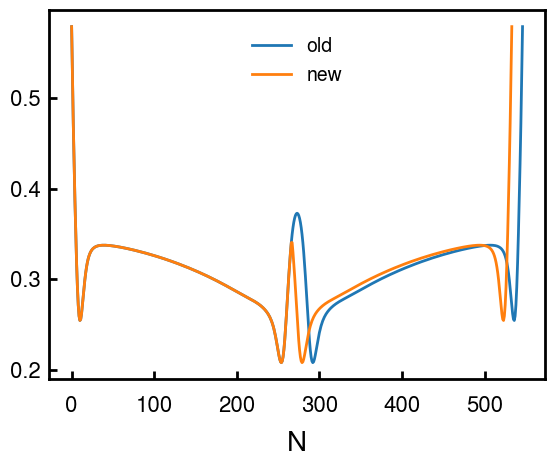

In [34]:
## Adjust D (half-space)
filename = 'W_lx062-p11.dat' 
fill_mid = True # Add to mid (Sep) if True, add to ends (Con) if False
dx = 17/150
new_Lx = 60.5
N = round(new_Lx / dx)

names = ['*', 'w1','w2','w3','w4','w5', '**', 'wb', 'eta', 'pot_elec']
df = pd.read_csv(GIT+filename, sep='\s+', skiprows=0, names=names)
old_N = len(df.index)

if N >= old_N: 
    if fill_mid == True:
        mid = round(old_N/2)
        rem = df.iloc[mid,:].values.tolist() 
        rem = pd.DataFrame([rem for i in range(N-2*mid)], columns=names)
        new = pd.concat([df.iloc[:round(old_N/2)], rem, df.iloc[-round(old_N/2):]], ignore_index=True)
    else: 
        end = 0 
        rem = df.iloc[end,:].values.tolist() 
        rem = pd.DataFrame([rem for i in range(N-old_N)], columns=names)
        new = pd.concat([rem.iloc[:round((N-old_N)/2)], df, rem[round((N-old_N)/2):]], ignore_index=True)
else: 
    shave = df.iloc[0:round(N/2),:]
    new = pd.concat([shave, shave.iloc[::-1]], ignore_index=True)
    
if N == len(new.index): 
    print('Success: {:d} == {:d}.'.format(N, len(new.index)))
    print('Actual Lx: {:.2f}'.format(N*dx))
    new.to_csv('./imgs/W_in{}.dat'.format(round(new_Lx)), sep='\t', float_format='%10.5e', header=False, index=False)
else:
    print('Fail: {:d} N versus {:d} New'.format(N, len(new.index)))
    
if True: 
    plt.plot(df.w1, label='old')
    plt.plot(new.w1, label='new')
    plt.legend()
    plt.xlabel('N')

Success: 538 == 538.


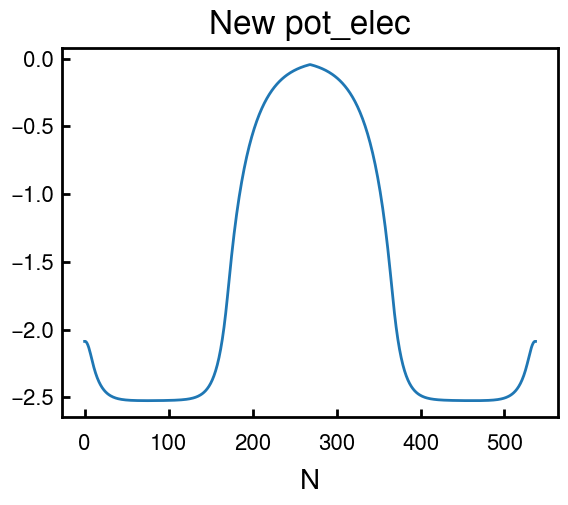

In [23]:
## SINGLE --> DOUBLE WA
filename = 'W_a035x110_1C.dat' #Nx = 100, dx = 17.0/150
dx = 17/150
new_Lx = 61
N = round(new_Lx / dx)

# names = ['*', 'w1','w2','w3','w4','w5', '**', 'wb', 'eta', 'pot_elec']
names = ['*', 'w1', '**', 'wb', 'eta', 'pot_elec']
df = pd.read_csv(GIT+filename, sep='\s+', skiprows=0, names=names)
# display(df)

if N > 2*len(df.index): 
    rem = ['['] + [1.00]*5 + [']'] + [-1.00]*2 + [0.00]
    rem = pd.DataFrame([rem for i in range(N-2*len(df.index))], columns=names)
    new = pd.concat([df, rem, df.iloc[::-1]], ignore_index=True)
else: 
    shave = df.iloc[0:round(N/2),:]
    new = pd.concat([shave, shave.iloc[::-1]], ignore_index=True)
    
if N == len(new.index): 
    print('Success: {:d} == {:d}.'.format(N, len(new.index)))
    new.to_csv('./imgs/W_sym{}.dat'.format(new_Lx), sep='\t', float_format='%10.5e', header=False, index=False)
else:
    print('Fail: {:d} N versus {:d} New'.format(N, len(new.index)))
    
if True:
    plt.plot(new.pot_elec)
    plt.title('New pot_elec')
    plt.xlabel('N')

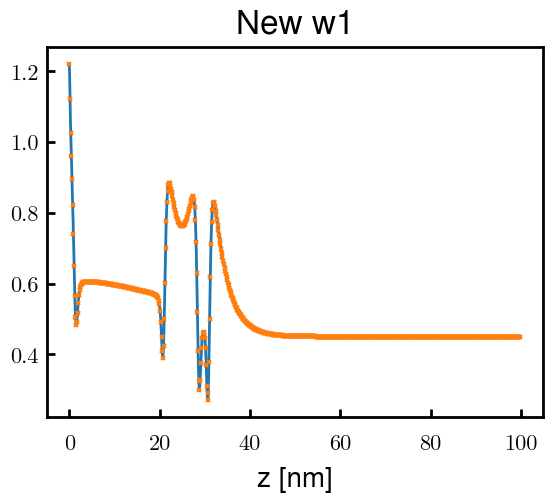

In [7]:
## SINGLE dx1 --> dx2
from scipy.interpolate import CubicSpline
filename = 'W_a040x145_1D.dat' #Nx = 75, dx = 17.0/150
dx1 = 17.0/150 # Old
dx2 = 0.15 # New
Lx = 100-dx1
Nx1, Nx2 = round(Lx/dx1), round(Lx/dx2)

x1 = np.arange(0, Lx, dx1)
x2 = np.arange(0, Lx, dx2)

names = ['*', 'w1', '**', 'wb', 'eta', 'pot_elec']
df = pd.read_csv(GIT+filename, sep='\s+', skiprows=0, names=names)

if True: 
    test_frame = df.w1
    cs = CubicSpline(x1, test_frame)
    plt.plot(x1, test_frame)
    plt.plot(x2, cs(x2), 'x', markerfacecolor='w', ms=3)

    plt.title('New w1')
    plt.xlabel('z [nm]')
    tjy.ticks()
    plt.show()

A = []
for i in [1, 3,4,5]:
    cs = CubicSpline(x1, df.iloc[:, i])
    A = [*A, cs(x2)]
fill = np.array(['[']*(Nx2))
fill2= np.array([']']*(Nx2))
A = [fill, A[0], fill2, A[1], A[2], A[3]]
new = pd.DataFrame(A).transpose()
new.to_csv('./imgs/W_dx{:d}.dat'.format(int(dx2*100)), sep=' ', float_format='%10.5e', header=False, index=False)

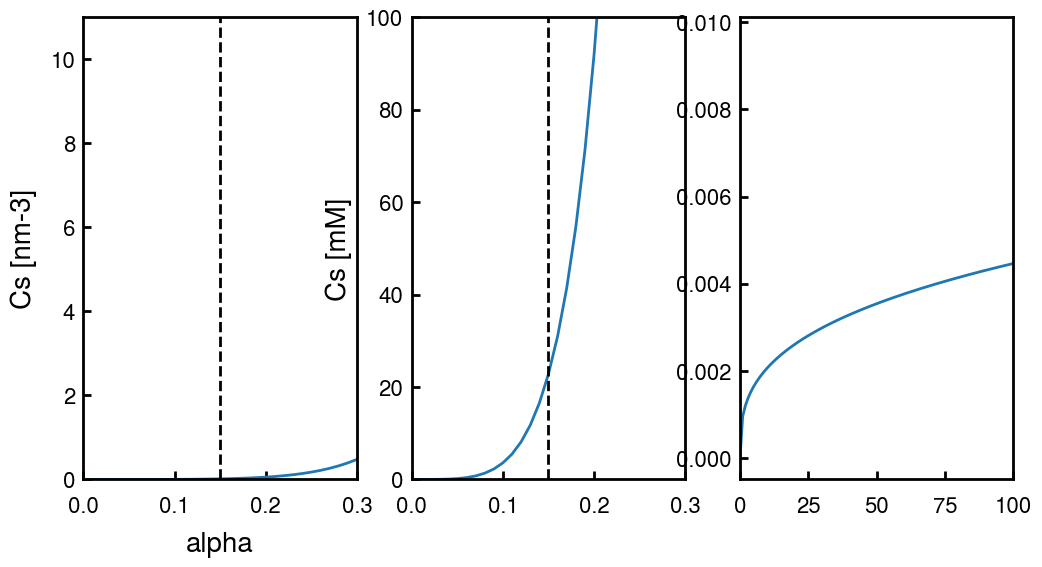

In [109]:
x = np.arange(0, 1, 0.01)
y = lambda x: 0.7 * 150**2 * (x / (1-x))**4 * 0.03**2

f, axs = plt.subplots(1, 3, figsize=(12,6))

axs[0].plot(x, y(x))
xx = 0.15
axs[0].plot([xx,xx], [0, 100], '--k')
axs[0].set_ylabel('Cs [nm-3]')
axs[0].set_xlabel('alpha')
axs[0].set_ylim(0, 11.0)
axs[0].set_xlim(0, 0.3)

axs[1].plot(x, y(x) * 1e27/1e3/6.022e23*1000)
axs[1].plot([xx,xx], [0, 5000], '--k')
axs[1].set_ylabel('Cs [mM]')
axs[1].set_ylim(0, 100)
axs[1].set_xlim(0, 0.3)

cs = np.arange(0, 1000)
alpha = lambda x: (0.1 / (1-0.1) * 0.03**2 * (x)/400**2/0.7)**(1/3)
axs[2].plot(cs, alpha(cs))
axs[2].set_xlim(0, 100)
plt.show()